In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import datetime
import copy
from utils.es_utils import *
from utils.env_utils import *
from utils.train_utils import *
import torch.nn.functional as F
from models.Buffer import Buffer
from models.PredatorPolicy import PredatorPolicy
from models.PreyPolicy import PreyPolicy
from models.DeepGenerator import GeneratorPolicy
from models.Discriminator import Discriminator
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *

In [2]:
# Training Folder
#path = r"..\data\pretuning"
#timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
#folder_name = f"Pretuning - {timestamp}"

path = r"..\models\trained_policies"

#save_dir = os.path.join(path, folder_name)
os.makedirs(path, exist_ok=True)

data_path = rf'..\data\processed\pred_prey_interactions\expert_tensors\flagged\yolo_tensors'
couzin_path = rf"..\data\processed\couzin_interactions"
hl_path = rf'..\data\processed\pred_prey_interactions\expert_tensors\flagged\hl_tensors'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = PredatorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = PreyPolicy().to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=200000, device=device)

In [4]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(couzin_path)
expert_buffer.clear(p=80)               # Reduce ratio of non-attack data by 90%. now ~equal
# 70 ist hier zu wenig. Mehr auf hand-labeled trainieren
#expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824
#expert_buffer.add_expert(hl_path)
len_exp_pred, len_exp_prey = expert_buffer.lengths()

print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  200
Storage of Prey Expert Buffer:  6400 



In [5]:
def pretrain_policy_with_validation(policy, expert_buffer, role, val_ratio=0.2, pred_bs=256, prey_bs=512, epochs=10, lr=1e-3, device='cpu', early_stopping=True, patience=20):
    if role == 'predator':
        batch, _ = expert_buffer.sample(pred_bs, prey_bs)
    else:
        _, batch = expert_buffer.sample(pred_bs, prey_bs)

    states  = batch[..., :4]
    actions = batch[:, 0, 4].squeeze()

    dataset = TensorDataset(states, actions)
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    bs = pred_bs if role=='predator' else prey_bs
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False)

    policy.to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    train_losses, val_losses = [], []

    # Early-Stopping-Tracking
    patience_counter = 0
    best_val_loss = float('inf')
    best_state = copy.deepcopy(policy.state_dict())
    stopped_early = False

    for epoch in range(1, epochs + 1):
        # ---- Train ----
        policy.train()
        total_train_loss = 0.0
        for batch_states, batch_actions in train_loader:
            batch_states  = batch_states.to(device)
            batch_actions = batch_actions.to(device)

            if role == 'predator':
                actions, mu, sigma, weights = policy.forward(batch_states)
            else:
                actions, mu, sigma, weights, gain = policy.forward(batch_states)
                
            loss = F.mse_loss(actions, batch_actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch_states.size(0)

        avg_train_loss = total_train_loss / train_size
        train_losses.append(avg_train_loss)

        # ---- Validation ----
        policy.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch_states, batch_actions in val_loader:
                batch_states  = batch_states.to(device)
                batch_actions = batch_actions.to(device)

                if role == 'predator':
                    actions, mu, sigma, weights = policy.forward(batch_states)
                else:
                    actions, mu, sigma, weights, gain = policy.forward(batch_states)

                loss = F.mse_loss(actions, batch_actions)
                total_val_loss += loss.item() * batch_states.size(0)

        avg_val_loss = total_val_loss / val_size
        val_losses.append(avg_val_loss)

        # best checkpoint nach Val-Loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = copy.deepcopy(policy.state_dict())

        if role == 'predator':
            print(f"[{role.upper()}] Epoch {epoch:02d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        else:
            #print(f"[{role.upper()}] Epoch {epoch:02d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Pred Gain: {gain.mean().item():.6f}")

            print(f"[{role.upper()}] Epoch {epoch:02d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Pred Gain: {gain}")
            
        if early_stopping:
            if avg_val_loss > avg_train_loss:
                patience_counter += 1
            else:
                patience_counter = 0

            if patience_counter >= patience:
                print(f"[{role.upper()}] Early stopping nach {epoch} Epochen (Val > Train {patience}× in Folge).")
                stopped_early = True
                break

    # bestes Modell wiederherstellen
    policy.load_state_dict(best_state)

    # Plot
    epochs_run = len(train_losses)
    plt.figure()
    plt.plot(range(1, epochs_run + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs_run + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f"{role.capitalize()} Loss Curves" + (" (early stopped)" if stopped_early else ""))
    plt.legend()
    plt.show()

    return policy

[PREDATOR] Epoch 01 | Train Loss: 0.473760 | Val Loss: 0.615290
[PREDATOR] Epoch 02 | Train Loss: 0.464278 | Val Loss: 0.629300
[PREDATOR] Epoch 03 | Train Loss: 0.364930 | Val Loss: 0.806354
[PREDATOR] Epoch 04 | Train Loss: 0.411933 | Val Loss: 0.542997
[PREDATOR] Epoch 05 | Train Loss: 0.368970 | Val Loss: 0.734254
[PREDATOR] Epoch 06 | Train Loss: 0.399140 | Val Loss: 0.500447
[PREDATOR] Epoch 07 | Train Loss: 0.379348 | Val Loss: 0.820472
[PREDATOR] Epoch 08 | Train Loss: 0.313908 | Val Loss: 0.593317
[PREDATOR] Epoch 09 | Train Loss: 0.278901 | Val Loss: 0.577276
[PREDATOR] Epoch 10 | Train Loss: 0.423210 | Val Loss: 0.848611
[PREDATOR] Epoch 11 | Train Loss: 0.301098 | Val Loss: 0.390135
[PREDATOR] Epoch 12 | Train Loss: 0.352735 | Val Loss: 0.608189
[PREDATOR] Epoch 13 | Train Loss: 0.268000 | Val Loss: 0.603380
[PREDATOR] Epoch 14 | Train Loss: 0.316869 | Val Loss: 0.520317
[PREDATOR] Epoch 15 | Train Loss: 0.330625 | Val Loss: 0.478418
[PREDATOR] Epoch 16 | Train Loss: 0.2844

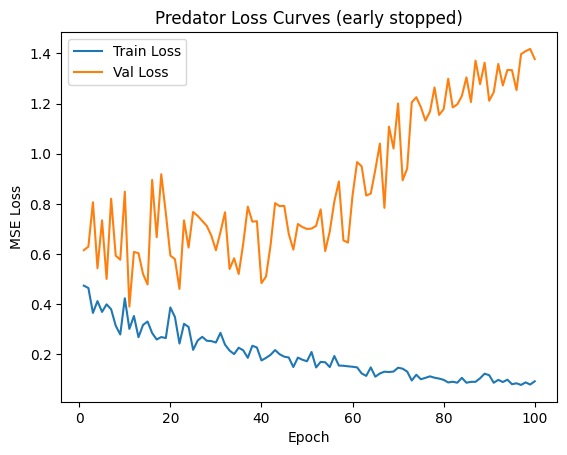

In [7]:
pred_policy = pretrain_policy_with_validation(pred_policy, expert_buffer, role='predator', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=600, lr=1e-3, device='cpu', early_stopping=True, patience=100)
torch.save(pred_policy, os.path.join(path, "bc_pred_policy.pt"))

In [8]:
prey_policy = pretrain_policy_with_validation(prey_policy, expert_buffer, role='prey', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=2000, lr=1e-3, device='cpu', early_stopping=True, patience=50)
torch.save(prey_policy, os.path.join(path, "bc_prey_policy.pt"))

[PREY] Epoch 01 | Train Loss: 1.178144 | Val Loss: 1.090373 | Pred Gain: 0.499750018119812
[PREY] Epoch 02 | Train Loss: 1.167313 | Val Loss: 1.213234 | Pred Gain: 0.49950000643730164
[PREY] Epoch 03 | Train Loss: 1.142759 | Val Loss: 1.155280 | Pred Gain: 0.4992501139640808
[PREY] Epoch 04 | Train Loss: 1.124411 | Val Loss: 1.209971 | Pred Gain: 0.4990006387233734
[PREY] Epoch 05 | Train Loss: 1.145112 | Val Loss: 1.128811 | Pred Gain: 0.49875107407569885
[PREY] Epoch 06 | Train Loss: 1.153377 | Val Loss: 1.195145 | Pred Gain: 0.49850162863731384
[PREY] Epoch 07 | Train Loss: 1.132208 | Val Loss: 1.276811 | Pred Gain: 0.4982524514198303
[PREY] Epoch 08 | Train Loss: 1.103781 | Val Loss: 1.246553 | Pred Gain: 0.49800369143486023
[PREY] Epoch 09 | Train Loss: 1.120558 | Val Loss: 1.075326 | Pred Gain: 0.4977548122406006
[PREY] Epoch 10 | Train Loss: 1.133974 | Val Loss: 1.185289 | Pred Gain: 0.49750566482543945
[PREY] Epoch 11 | Train Loss: 1.167520 | Val Loss: 1.155229 | Pred Gain: 0.4

KeyboardInterrupt: 

In [ ]:
# Expert Data
total_detections=33
ftw_path = rf"..\data\processed\pred_prey_interactions\full_track_windows\{total_detections}"

start_frame_pool = Pool(max_length=12100, device=device)
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [ ]:
def run_policies2(env, pred_policy, prey_policy, prey_features=4): 
    print("Press 'q' to end simulation.")

    metrics = []

    while True:
        if keyboard.is_pressed('q'):
            break

        global_state = env.state().item()
        pred_tensor, prey_tensor, xs, ys, dx, dy, vxs, vys = get_eval_features(global_state)

        pred_states = pred_tensor[..., :4]
        actions, mu, sigma, weights = pred_policy.forward(pred_states)
        dis_pred = continuous_to_discrete(actions, 360, role='predator')

        prey_states = prey_tensor[..., :4]
        actions, mu, sigma, weights, gain = prey_policy.forward(prey_states)
        dis_prey = continuous_to_discrete(actions, 360, role='prey')

        action_dict = {'predator_0': dis_pred}
        for i, agent_name in enumerate(sorted([agent for agent in env.agents if agent.startswith("prey")])):
            action_dict[agent_name] = dis_prey[i]

        env.step(action_dict)

        metrics.append({"polarization": compute_polarization(vxs, vys),
                        "angular_momentum": compute_angular_momentum(xs, ys, vxs, vys),
                        "mean_pairwise_distance": mean_pairwise_distance(dx, dy),
                        "xs": xs,
                        "ys": ys,
                        "dx": dx,
                        "dy": dy,
                        "vxs": vxs,
                        "vys": vys})
        
        env.render()

    try:
        env.close()
    except:
        pass

    return metrics

In [ ]:
'''
Prey Reward:
- Survival per time step +0,01
- Distance to predator +0,001


Predator Reward:
Catch +1

'''

In [ ]:
env = parallel_env(predator_count=1, prey_count=20, action_count=360, use_walls=False, predator_reward=10, prey_punishment=100, prey_reward=1)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
metrics = run_policies2(env, pred_policy, prey_policy, prey_features=5)

Press 'q' to end simulation.
